In [1]:
from Simulation.mpc import *
from Simulation.systemFunctions import DistillationColumnAspen
from utils.helpers import *

## Initialize the system

In [2]:
# System and Snapshot paths
path = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\C2S_SS_simulation4.dynf"
path_snaps = r"C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation4"

In [3]:
# First initiate the system
# Nominal Conditions
nominal_conditions =  np.array([1.50032484e+05, -2.10309105e+01, 2.08083248e+01, 6.30485237e-01, 3.69514734e-01, -2.40000000e+01])

# Steady State inputs
ss_inputs = np.array([320000.0, 110.0])

# Sampling time of the system
delta_t = 1 / 6 # 10 mins

In [4]:
# steady state values
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
steady_states={"ss_inputs":dl.ss_inputs,
               "y_ss":dl.y_ss}
print(steady_states)
dl.close(path_snaps)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
{'ss_inputs': array([3.2e+05, 1.1e+02]), 'y_ss': array([  0.1003974 , -22.95514339])}
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation4\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation4\snpA0001.snp


## Loading the system matrices, min max scaling, and min max of the states

In [5]:
dir_path = os.path.join(os.getcwd(), "Data")

In [6]:
# Defining the range of setpoints for data generation
setpoint_y = np.array([[0.002, -26.0],
                       [0.05, -16.0]])
u_min = np.array([300000.0, 100.0])
u_max = np.array([460000, 150.0])

system_data = load_and_prepare_system_data(steady_states=steady_states, setpoint_y=setpoint_y, u_min=u_min, u_max=u_max)

In [7]:
A_aug = system_data["A_aug"]
B_aug = system_data["B_aug"]
C_aug = system_data["C_aug"]

In [8]:
data_min = system_data["data_min"]
data_max = system_data["data_max"]

In [9]:
min_max_states = system_data["min_max_states"]

In [10]:
y_sp_scaled_deviation = system_data["y_sp_scaled_deviation"]

In [11]:
b_min = system_data["b_min"]
b_max = system_data["b_max"]

In [12]:
min_max_dict = system_data["min_max_dict"]

In [13]:
# Setpoints in deviation form
inputs_number = int(B_aug.shape[1])
y_sp_scenario = np.array([[0.013, -23.],
                         [0.018, -22.]])

y_sp_scenario = (apply_min_max(y_sp_scenario, data_min[inputs_number:], data_max[inputs_number:])
                 - apply_min_max(steady_states["y_ss"], data_min[inputs_number:], data_max[inputs_number:]))

n_tests = 2
set_points_len = 200
TEST_CYCLE = [False, False, False, False, False]
warm_start = 5
ACTOR_FREEZE = 4 * set_points_len
warm_start_plot = warm_start * 2 * set_points_len + ACTOR_FREEZE

In [14]:
# # # Observer Gain
# poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
#                   0.01153274, 0.41036367])
# L = compute_observer_gain(A_aug, C_aug, poles)
# L
# # Observer Gain
poles = np.array([0.032, 0.03501095, 0.04099389, 0.04190188, 0.07477281,
                  0.5153274, 0.61036367])
# poles = np.array([0.6, 0.6, 0.55, 0.5, 0.5, 0.98, 0.95])
L = compute_observer_gain(A_aug, C_aug, poles)
L

The system is observable.


array([[ 2.61314809e-02, -7.33441466e-04],
       [ 9.57826516e-03,  2.16807172e-01],
       [-6.17077864e-01, -3.83532624e-02],
       [-5.94942729e-04, -5.93262013e-02],
       [-9.27639419e-03, -2.11065507e-01],
       [ 2.13090070e+00,  5.59402572e-02],
       [ 2.09290486e-02,  1.65750104e+00]])

## Setting The hyperparameters for the TD3 Agent

In [15]:
from TD3Agent.agent import TD3Agent
import torch

In [31]:
set_points_number = int(C_aug.shape[0])
STATE_DIM = int(A_aug.shape[0]) + set_points_number + inputs_number
ACTION_DIM = int(B_aug.shape[1])
n_outputs = C_aug.shape[0]
ACTOR_LAYER_SIZES = [256, 256, 256]
CRITIC_LAYER_SIZES = [256, 256, 256]
BUFFER_CAPACITY = 200000
ACTOR_LR = 1e-6
CRITIC_LR = 1e-4
SMOOTHING_STD = 0.005
NOISE_CLIP = 0.1
EXPLORATION_NOISE_STD = 0.005
GAMMA = 0.99
TAU = 0.005
MAX_ACTION = 1
POLICY_DELAY = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 512
STD_START = 0.005
STD_END = 0.0
STD_DECAY_RATE = 0.99995
STD_DECAY_MODE = "exp"

In [42]:
td3_agent = TD3Agent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    actor_hidden=ACTOR_LAYER_SIZES,
    critic_hidden=CRITIC_LAYER_SIZES,
    gamma=GAMMA,
    actor_lr=ACTOR_LR,
    critic_lr=CRITIC_LR,
    batch_size=BATCH_SIZE,
    policy_delay=POLICY_DELAY,
    target_policy_smoothing_noise_std=SMOOTHING_STD,
    noise_clip=NOISE_CLIP,
    max_action=MAX_ACTION,
    tau=TAU,
    std_start=STD_START,
    std_end=STD_END,
    std_decay_rate=STD_DECAY_RATE,
    std_decay_mode=STD_DECAY_MODE,
    buffer_size=BUFFER_CAPACITY,
    device=DEVICE,
    actor_freeze=ACTOR_FREEZE,
    )

In [43]:
agent_path = r"C:\Users\HAMEDI\Desktop\DistillRL\Data/models\td3_20251109_192343.pkl"
# agent_path = r"C:\Users\HAMEDI\Desktop\DistillRL\Data/models\td3_20251017_143115.pkl"
td3_agent.load(agent_path)

Agent loaded successfully from: C:\Users\HAMEDI\Desktop\DistillRL\Data/models\td3_20251109_192343.pkl


## MPC initialization

In [44]:
# MPC parameters
predict_h = 6
cont_h = 3
b1 = (b_min[0], b_max[0])
b2 = (b_min[1], b_max[1])
bnds = (b1, b2)*cont_h
cons = []
IC_opt = np.zeros(inputs_number*cont_h)
Q1_penalty = 1.
Q2_penalty = 1.
R1_penalty = 1.
R2_penalty = 1.

In [45]:
MPC_obj = MpcSolver(A_aug, B_aug, C_aug,
                    Q1_penalty, Q2_penalty, R1_penalty, R2_penalty,
                    predict_h, cont_h)

In [46]:
def run_rl(system, y_sp_scenario, n_tests, set_points_len,
           steady_states, min_max_dict, agent, MPC_obj,
           Q1_penalty, Q2_penalty, R1_penalty, R2_penalty, L, data_min, data_max, n_inputs):
    # defining setpoints
    y_sp, nFE, sub_episodes_changes_dict, time_in_sub_episodes = generate_setpoints(y_sp_scenario, n_tests,
                                                                                    set_points_len)

    # Set exploration to False
    agent.warm_start = False

    # Output of the system
    y_system = np.zeros((nFE + 1, MPC_obj.C.shape[0]))
    y_system[0, :] = system.current_output

    # RL inputs
    u_rl = np.zeros((nFE, MPC_obj.B.shape[1]))

    # Record states of the state space model
    xhatdhat = np.zeros((MPC_obj.A.shape[0], nFE + 1))
    yhat = np.zeros((MPC_obj.C.shape[0], nFE))

    # Reward recording
    rewards = np.zeros(nFE)
    avg_rewards = []

    # Scaled steady states inputs and outputs
    ss_scaled_inputs = apply_min_max(steady_states["ss_inputs"], data_min[:n_inputs], data_max[:n_inputs])
    y_ss_scaled = apply_min_max(steady_states["y_ss"], data_min[n_inputs:], data_max[n_inputs:])

    # Minimum and Maximum of the rl action
    u_min, u_max = min_max_dict["u_min"], min_max_dict["u_max"]

    for i in range(nFE):
        # So we need to apply scaling for rl because the formulation of the MPC was in scaled deviation
        # current input needs to be scaled and then deviation form
        # y_sp is already in scaled and deviation form
        # States from state space model is scaled deviation from as well
        scaled_current_input = apply_min_max(system.current_input, data_min[:n_inputs], data_max[:n_inputs])
        scaled_current_input_dev = scaled_current_input - ss_scaled_inputs

        # Set the current state
        current_rl_state = apply_rl_scaled(min_max_dict, xhatdhat[:, i], y_sp[i, :], scaled_current_input_dev)

        # Taking the action of the TD3 Agent
        action = agent.take_action(current_rl_state)

        # First converting the action into the scaled mpc from rl scaled
        u = ((action + 1.0) / 2.0) * (u_max - u_min) + u_min

        # take the control action (this is in scaled deviation form)
        u_rl[i, :] = u + ss_scaled_inputs

        # u (reverse scaling of the mpc)
        u_plant = reverse_min_max(u_rl[i, :], data_min[:n_inputs], data_max[:n_inputs])

        # Calculate Delta U in scaled deviation form
        delta_u = (u_rl[i, :] - ss_scaled_inputs) - (scaled_current_input - ss_scaled_inputs)

        # Change the current input
        system.current_input = u_plant

        # Apply the action on the system
        system.step()

        # Record the system output
        y_system[i + 1, :] = system.current_output

        # Since the state space calculation is in scaled will transform it
        y_current_scaled = apply_min_max(y_system[i, :], data_min[n_inputs:], data_max[n_inputs:]) - y_ss_scaled

        # Calculate Delta y in deviation form
        delta_y = y_current_scaled - y_sp[i, :]

        # Calculate the next state in deviation form
        yhat[:, i] = np.dot(MPC_obj.C, xhatdhat[:, i])
        xhatdhat[:, i + 1] = np.dot(MPC_obj.A, xhatdhat[:, i]) + np.dot(MPC_obj.B,
                                                                        (u_rl[i, :] - ss_scaled_inputs)) + \
                             np.dot(L, (y_current_scaled - yhat[:, i])).T

        # Reward Calculation
        reward = - (Q1_penalty * delta_y[0] ** 2 + Q2_penalty * delta_y[1] ** 2 +
                    R1_penalty * delta_u[0] ** 2 + R2_penalty * delta_u[1] ** 2)

        # Record rewards
        rewards[i] = reward

        # Calculate average reward and printing
        if i in sub_episodes_changes_dict.keys():
            # Averaging the rewards from the last setpoint change till current
            avg_rewards.append(np.mean(rewards[i - time_in_sub_episodes + 1: i]))

            # printing
            print('Sub_Episode : ', sub_episodes_changes_dict[i], ' | avg. reward :', avg_rewards[-1])

    u_rl = reverse_min_max(u_rl, data_min[:n_inputs], data_max[:n_inputs])

    return y_system, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat

In [47]:
dl = DistillationColumnAspen(path, ss_inputs, nominal_conditions)
y_rl, u_rl, avg_rewards, rewards, xhatdhat, nFE, time_in_sub_episodes, y_sp, yhat = run_rl(dl, y_sp_scenario, n_tests, set_points_len,
            steady_states, min_max_dict, td3_agent, MPC_obj,
            Q1_penalty, Q2_penalty, R1_penalty, R2_penalty, L, data_min, data_max, inputs_number)

Initialization has been completed
Steady State has been completed
System is in open loop condition now!
Steady state reached!
Sub_Episode :  1  | avg. reward : -0.0008396162033796146
Sub_Episode :  2  | avg. reward : -0.00013213039691893375


In [48]:
save_path = os.path.join(dir_path, "mpc_results_200.pickle")
with open(save_path, 'rb') as file:
    mpc_results = pickle.load(file)

In [49]:
dl.close(path_snaps)

Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation4\snpA0000.snp
Deleted the last created snapshot starting with 'snp': C:/Users\HAMEDI\Desktop\FinalDocuments\FinalDocuments\C2SplitterControlFiles\AspenFiles\dynsim\Plant\AM_C2S_SS_simulation4\snpA0001.snp


In [50]:
def plot_rl_mpc(y_sp, steady_states, nFE, delta_t, y_rl, u_rl, mpc_results, data_min,
                data_max, xhatdhat):
    # Canceling the deviation form
    y_ss = apply_min_max(steady_states["y_ss"], data_min[2:], data_max[2:])
    y_sp = (y_sp + y_ss)
    y_sp = (reverse_min_max(y_sp, data_min[2:], data_max[2:])).T

    time_plot = np.linspace(0, nFE * delta_t, nFE + 1)

    y_mpc = mpc_results["y_mpc"]
    u_mpc = mpc_results["u_mpc"]
    xhatdhat_mpc = mpc_results["xhatdhat"]

    ####### Plot 1  ###############

    plt.figure(figsize=(10, 8))

    # First subplot
    plt.subplot(2, 1, 1)
    plt.plot(time_plot[10:], y_rl[10:, 0], 'b-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot[10:], y_mpc[10:, 0], 'y--', lw=2, label=r'$\mathbf{MPC}$')
    plt.step(time_plot[10:-1], y_sp[0, 10:], 'r--', lw=2, label=r'$\mathbf{Setpoint}$')
    plt.ylabel(r'$\mathbf{Tray 24 Ethane Comp.}$', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    # Second subplot
    plt.subplot(2, 1, 2)
    plt.plot(time_plot[10:], y_rl[10:, 1], 'b-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot[10:], y_mpc[10:, 1], 'y--', lw=2, label=r'$\mathbf{MPC}$')
    plt.step(time_plot[10:-1], y_sp[1, 10:], 'r--', lw=2, label=r'$\mathbf{Setpoint}$')
    plt.ylabel(r'$\mathbf{Tray 85 Temp.}$ (C)', fontsize=18)
    plt.xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)

    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

    ####### Plot 2  ###############
    plt.figure(figsize=(10, 8))

    # First subplot
    plt.subplot(2, 1, 1)
    plt.plot(time_plot[:-1], u_rl[:, 0], 'r-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot[:-1], u_mpc[:, 0], 'b--', lw=2, label=r'$\mathbf{MPC}$')
    plt.ylabel(r'$\mathbf{R}$ (kg/h)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    # Second subplot
    plt.subplot(2, 1, 2)
    plt.plot(time_plot[:-1], u_rl[:, 1], 'r-', lw=2, label=r'$\mathbf{RL}$')
    plt.plot(time_plot[:-1], u_mpc[:, 1], 'b--', lw=2, label=r'$\mathbf{MPC}$')
    plt.ylabel(r'$\mathbf{Q}_R$ (Gj/h)', fontsize=18)
    plt.xlabel(r'$\mathbf{Time}$ (hour)', fontsize=18)
    plt.grid(True)
    plt.legend(loc='best', fontsize=16)

    plt.subplot(2, 1, 1)
    plt.tick_params(axis='both', labelsize=16)

    plt.subplot(2, 1, 2)
    plt.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

    ###### Plot 3 ########
    fig, axes = plt.subplots(nrows=xhatdhat.shape[0], ncols=1,
                             figsize=(10, 3 * xhatdhat.shape[0]),
                             sharex=True)

    for i in range(xhatdhat.shape[0]):
        # Plot RL (xhatdhat)
        axes[i].plot(time_plot, xhatdhat[i, :], 'r-', lw=2, label='RL')
        # Plot MPC (xhatdhat_mpc)
        axes[i].plot(time_plot, xhatdhat_mpc[i, :], 'y--', lw=2, label='MPC', alpha=0.6)

        # Labeling, grids, etc.
        axes[i].grid(True)
        axes[i].set_ylabel(f'State {i}', fontsize=14)
        axes[i].legend(loc='best', fontsize=12)

    # Label the bottom (shared) X-axis:
    axes[-1].set_xlabel('Time (h)', fontsize=14)

    fig.suptitle('Comparison of RL vs. MPC States', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

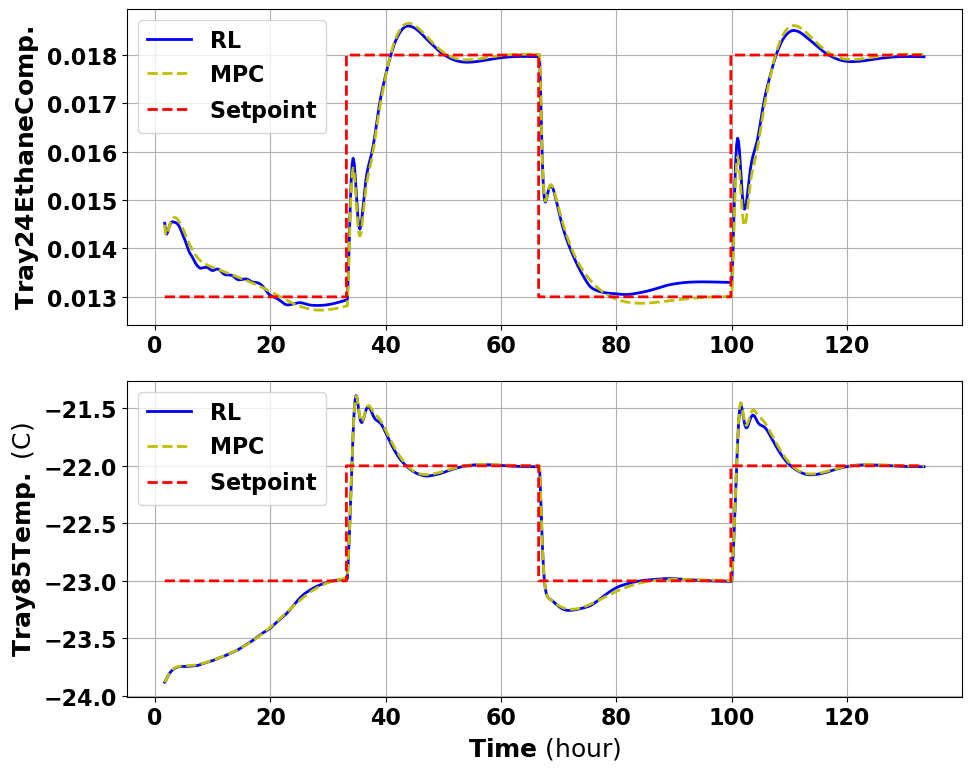

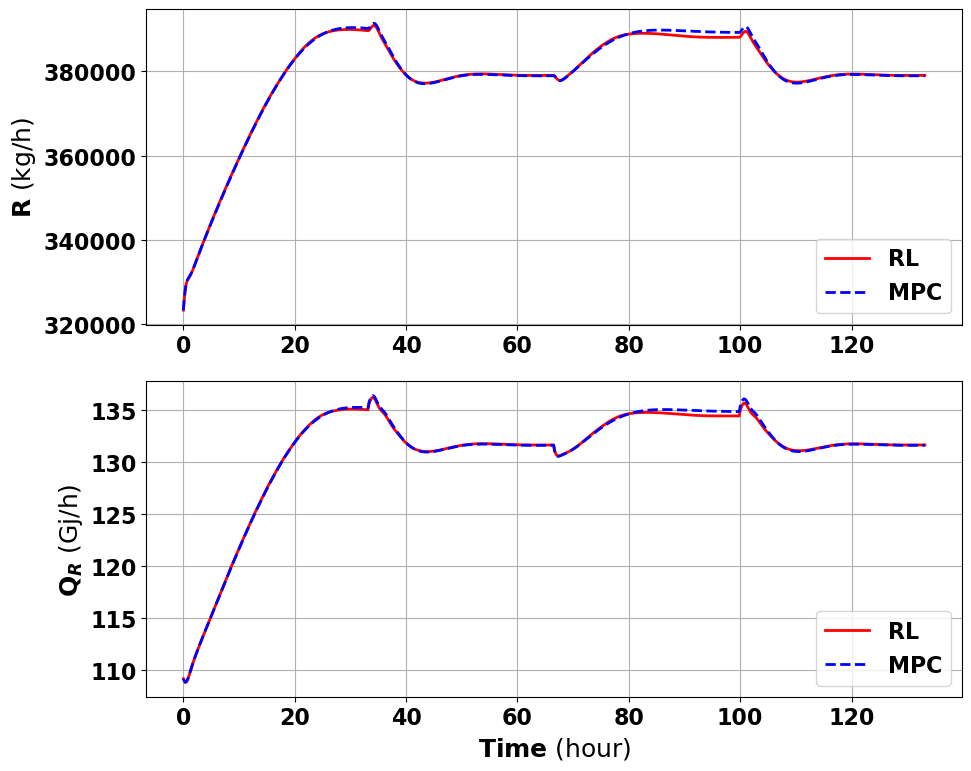

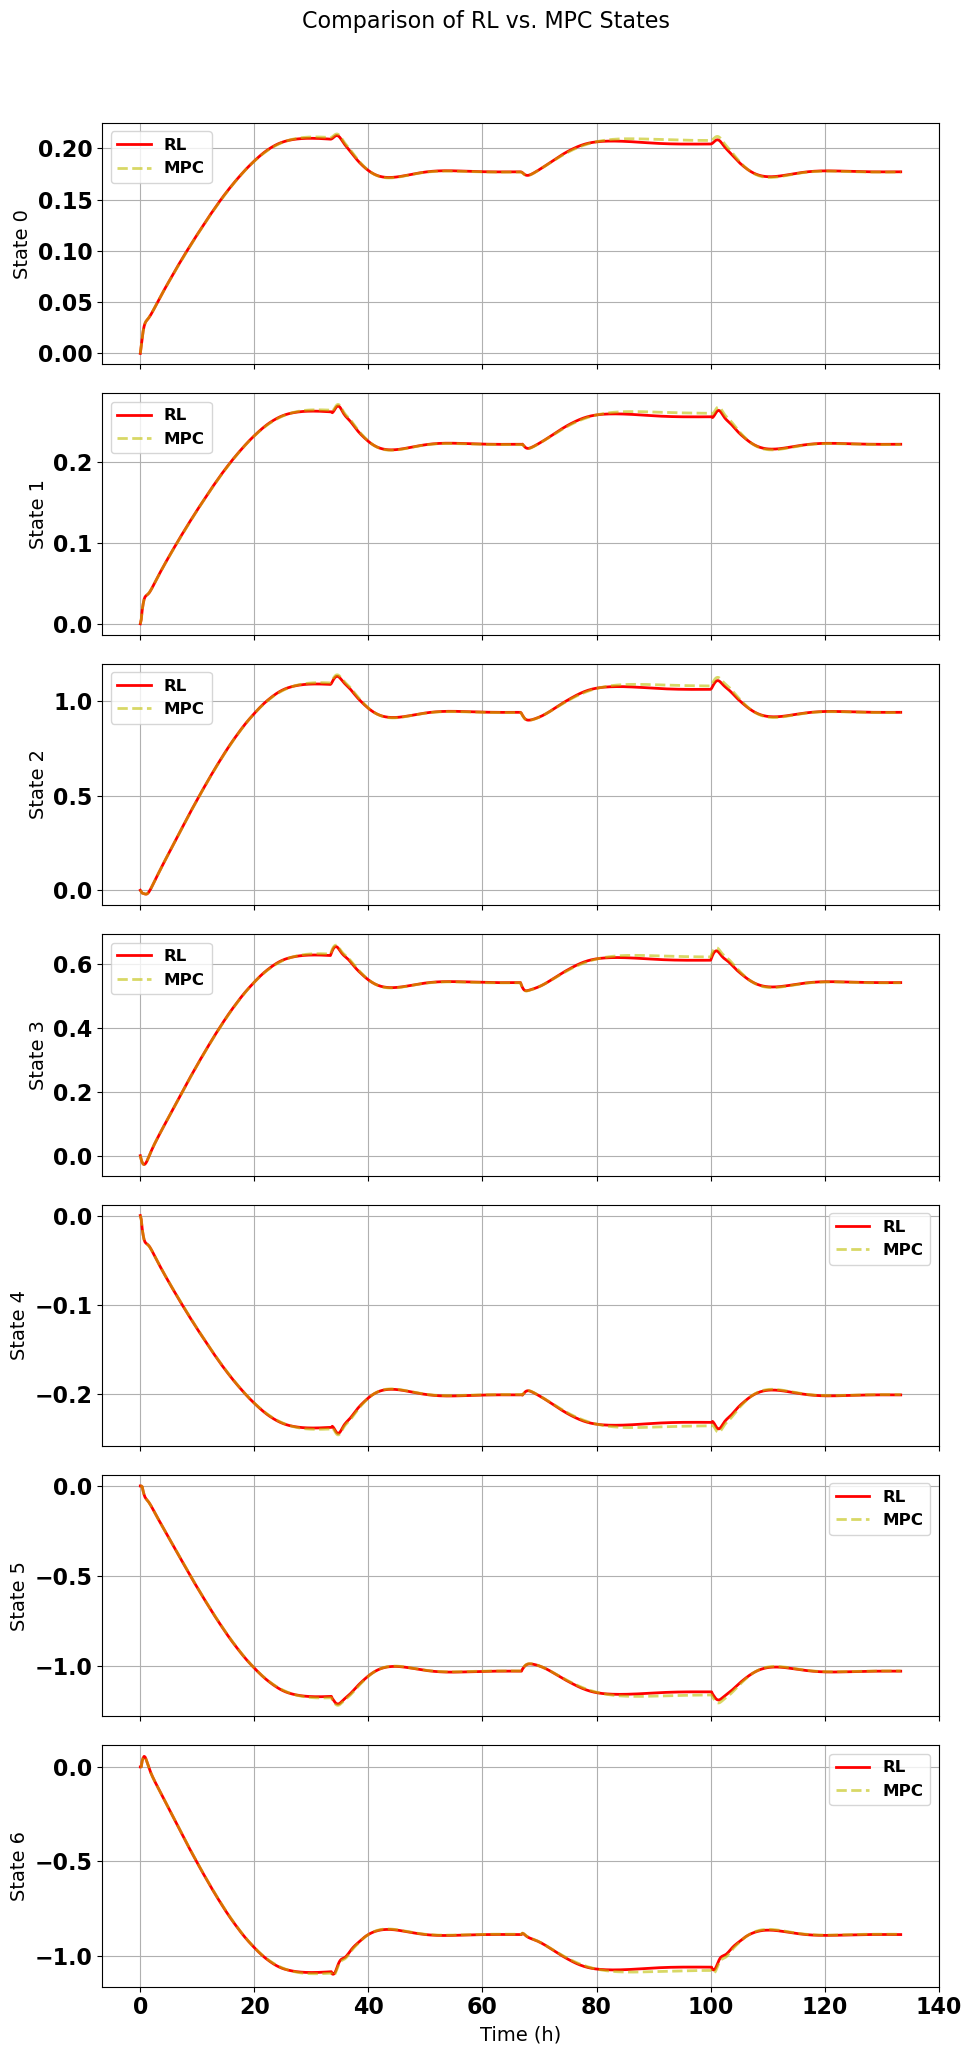

In [51]:
plot_rl_mpc(y_sp, steady_states, nFE, delta_t, y_rl, u_rl, mpc_results, data_min,
                data_max, xhatdhat)